In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.coord_categorisation
import iris.analysis.stats
from pathos.threading import ThreadPool as Pool
import matplotlib
from scipy.optimize import leastsq
import scipy.stats as spst
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings('ignore')

In [2]:
from f_statistics import *
from f_preprocessing import *
from f_significance_calculation_correlation import *

In [3]:
fol='/home/vanoorschot/work/fransje/confess_paper/'

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# colors =['lightgrey','lightgrey','lightgrey']
# cmap_grey = LinearSegmentedColormap.from_list('cm',colors, N=3)
colors =['gainsboro','gainsboro','gainsboro']
cmap_grey = LinearSegmentedColormap.from_list('cm',colors, N=3)
colors2 =['white','white','white']
cmap_white = LinearSegmentedColormap.from_list('cm',colors2, N=3)

In [5]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [6]:
cmap = cm.get_cmap('RdBu', 24)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color_list[11] = '#ffffff'
color_list[12] = '#ffffff'
cmap_rdbu = ListedColormap(color_list)

In [7]:
f_mod = f'{fol}/data/htessel_output/IAK5'
mod = xr.open_dataset(f'{f_mod}/o_veg_1999_2018_climatology.nc')
m = mod.var66.mean(dim='time')
mn = m.notnull()

In [8]:
tl_0_1 = ['0.0','','0.2','','0.4','','0.6','','0.8','','1.0']
tl_0_2 = ['0.0','','0.04','','0.08','','0.12','','0.16','','0.2']
tl_02 = ['-0.20','','-0.12','','-0.04','','0.04','','0.12','','0.20']
tl_01 = ['-0.10','','-0.06','','-0.02','','0.02','','0.06','','0.10']
tl_800=['0','','160','','320','','480','','640','','800']
tl_500=['0','','100','','200','','300','','400','','500']
tl_1500=['0','','300','','600','','900','','1200','','1500']
tl_05=['0.0','','0.1','','0.2','','0.3','','0.4','','0.5']
tl_005=['-0.05','','-0.03','','-0.01','','0.01','','0.03','','0.05']
tl_003=['-0.03','','-0.0015','','0','','0.0015','','0.03']

In [9]:
def corr_maps(exp_name1,exp_name2,name1,name2,lat_minb,lat_maxb,lon_minb,lon_maxb):
    for season in ['djf','jja']:
        ref_data = 'DOLCE_v3'
        start_year = '1999'
        end_year = '2018'
        var = 'hfls'
        reps=1000
        tp = f'ia anomalies {season}'
        
        if (lon_minb>180):
            lon_minb2 = lon_minb-360
            lon_maxb2 = lon_maxb-360
        else:
            lon_minb2,lon_maxb2 = lon_minb,lon_maxb

        #load quantiles
        tp2 = tp.replace(" ", "_")
        q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{season}_{ref_data}_{start_year}_{end_year}_corr_{dt}.nc')

        # calculate correlation
        rd=calculate_correlation_seasons(fol,ref_data,tp,start_year, end_year,var,name1,name2,season,dt)
        r=rd[0]
        r1=rd[1]
        r2=rd[2]

        # calculate area percentages of results
        cube = r.to_iris()
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)

        # without significance
        r = r.where(r.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        ap = areas.where(r>0) # positive correlation diff - improvement
        an = areas.where(r<0) # negative correlation diff - deterioration
        ap_p = ap.sum().values/a.sum().values # percentage of +
        an_p = an.sum().values/a.sum().values # percentage of -

        # with significance
        rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
        rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

        rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        asig = areas.where(rs2.notnull()) # all land points areas with data
        asigsum = asig.sum().values # total land area with data
        asigp = asigsum/asum
        aps = areas.where(rs2>0) # positive correlation diff - improvement
        ans = areas.where(rs2<0) # negative correlation diff - deterioration
        aps_p = aps.sum().values/a.sum().values # percentage of +
        ans_p = ans.sum().values/a.sum().values # percentage of -

        # mean + or - delta correlation
        rp = r.where(r>0).mean().values
        rn = r.where(r<0).mean().values

        rps = rs2.where(rs2>0).mean().values
        rns = rs2.where(rs2<0).mean().values

        rnull = r.isnull()

        r1w = r1.where((r1.lat>lat_minb)&(r1.lat<lat_maxb)&(r1.lon>lon_minb)&(r1.lon<lon_maxb))
        r2w = r2.where((r2.lat>lat_minb)&(r2.lat<lat_maxb)&(r2.lon>lon_minb)&(r2.lon<lon_maxb))
        rm1 = r1w.mean().values
        rm2 = r2w.mean().values

        lvls = np.linspace(-0.1,0.1,21)
        lvls3 = np.linspace(-0.1,0.1,11)
        lvls2 = np.linspace(-0.1,0.1,2) 

        n = r.notnull()
        fig = plt.figure(figsize=(8,8))
        ax = plt.subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        cf2 = n.plot.contourf(ax=ax, colors='gainsboro', hatches=['///'], add_colorbar=False)
        cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
        cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        if (sig=='sig_yes'):
            # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
            cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        ax.plot([lon_minb2,lon_maxb2],[lat_maxb,lat_maxb],'m-')
        ax.plot([lon_minb2,lon_maxb2],[lat_minb,lat_minb],'m-')
        ax.plot([lon_minb2,lon_minb2],[lat_minb,lat_maxb],'m-')
        ax.plot([lon_maxb2,lon_maxb2],[lat_minb,lat_maxb],'m-')
        cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl_01)
        ax.set_title(f'E corrdiff {name2}-{name1} {season}',size=16,loc='left')
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)
        ax.annotate(f'r1-box: {np.round(rm1,2)}',(-177,5), size=15,color='m')
        ax.annotate(f'r2-box: {np.round(rm2,2)}',(-177,-10), size=15,color='m')
        # fig.savefig(f'{fol}/data/htessel_output/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/correlation/seasons/corrdiff_E_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}_{seasons[i]}.jpg',dpi=300,bbox_inches='tight')

    for season in ['djf','jja']:
        start_year = '1999'
        # end_year = '2018'
        reps=1000
        tp = f'ia anomalies {season}'
        layer='layer1'
        th='60'
        #load quantiles
        tp2 = tp.replace(" ", "_")
        q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_ia_anomalies_esacci_{season}_{start_year}_{end_year}_corr_{dt}_{th}.nc')
        # plot correlation
        rd=calculate_correlation_SM_esa_seasons(fol,tp,start_year, end_year,name1,name2,layer,season,dt,th)
        r=rd[0]
        r1=rd[1]
        r2=rd[2]

        # calculate area percentages of results
        cube = r.to_iris()
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)

        # without significance
        r = r.where(r.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        ap = areas.where(r>0) # positive correlation diff - improvement
        an = areas.where(r<0) # negative correlation diff - deterioration
        ap_p = ap.sum().values/a.sum().values # percentage of +
        an_p = an.sum().values/a.sum().values # percentage of -

        # with significance
        rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
        rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

        rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        asig = areas.where(rs2.notnull()) # all land points areas with data
        asigsum = asig.sum().values # total land area with data
        asigp = asigsum/asum
        aps = areas.where(rs2>0) # positive correlation diff - improvement
        ans = areas.where(rs2<0) # negative correlation diff - deterioration
        aps_p = aps.sum().values/a.sum().values # percentage of +
        ans_p = ans.sum().values/a.sum().values # percentage of -

        # mean + or - delta correlation
        rp = r.where(r>0).mean().values
        rn = r.where(r<0).mean().values

        rps = rs2.where(rs2>0).mean().values
        rns = rs2.where(rs2<0).mean().values

        rnull = r.isnull()

        r1w = r1.where((r1.lat>lat_minb)&(r1.lat<lat_maxb)&(r1.lon>lon_minb)&(r1.lon<lon_maxb))
        r2w = r2.where((r2.lat>lat_minb)&(r2.lat<lat_maxb)&(r2.lon>lon_minb)&(r2.lon<lon_maxb))
        rm1 = r1w.mean().values
        rm2 = r2w.mean().values

        lvls = np.linspace(-0.1,0.1,21)
        lvls3 = np.linspace(-0.1,0.1,11)
        lvls2 = np.linspace(-0.1,0.1,2) 

        n = r.notnull()
        fig = plt.figure(figsize=(8,8))
        ax = plt.subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        cf2 = n.plot.contourf(ax=ax, colors='gainsboro', hatches=['///'], add_colorbar=False)
        cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
        cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        if (sig=='sig_yes'):
            # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
            cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        ax.plot([lon_minb2,lon_maxb2],[lat_maxb,lat_maxb],'m-')
        ax.plot([lon_minb2,lon_maxb2],[lat_minb,lat_minb],'m-')
        ax.plot([lon_minb2,lon_minb2],[lat_minb,lat_maxb],'m-')
        ax.plot([lon_maxb2,lon_maxb2],[lat_minb,lat_maxb],'m-')
        cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl_01)
        ax.set_title(f'SM corrdiff {name2}-{name1} {season}',size=16,loc='left')
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)
        ax.annotate(f'r1-box: {np.round(rm1,2)}',(-177,5), size=15,color='m')
        ax.annotate(f'r2-box: {np.round(rm2,2)}',(-177,-10), size=15,color='m')

## DROUGHT CASE

In [10]:
exp_name1='exp3'
exp_name2='exp6'
name1 = 'CTR'
name2 = 'IAKV'
start_year=1999
end_year=2018
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'
mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
dt = 'dt_yes'
sig = 'sig_yes'

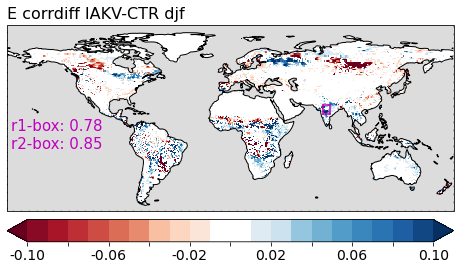

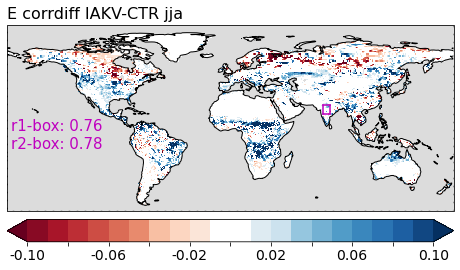

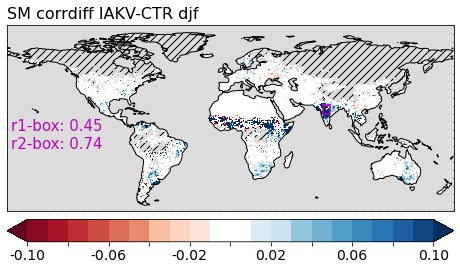

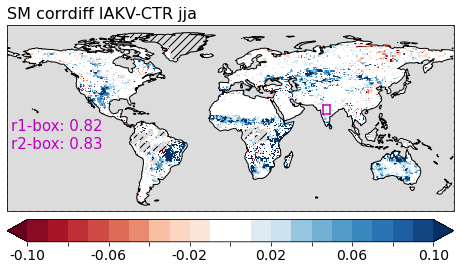

In [11]:
# India
lat_minb,lat_maxb = 18,25
lon_minb,lon_maxb = 75,80
corr_maps(exp_name1,exp_name2,name1,name2,lat_minb,lat_maxb,lon_minb,lon_maxb)

### DROUGHT - NORTH EAST BRAZIL

In [12]:
# NE brazil
exp_name1='exp3'
exp_name2='exp6'
name1 = 'CTR'
name2 = 'IAKV'
start_year=1999
end_year=2018
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'
mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
dt = 'dt_yes'
lat_minb,lat_maxb = -11,-3
lon_minb,lon_maxb = 316,325
start_date,end_date = '2010-07-15','2013-07-15'
sig='sig_yes'

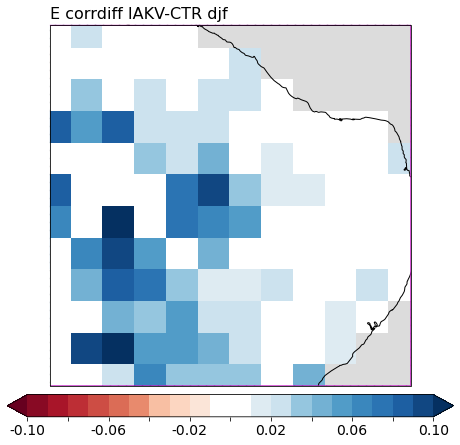

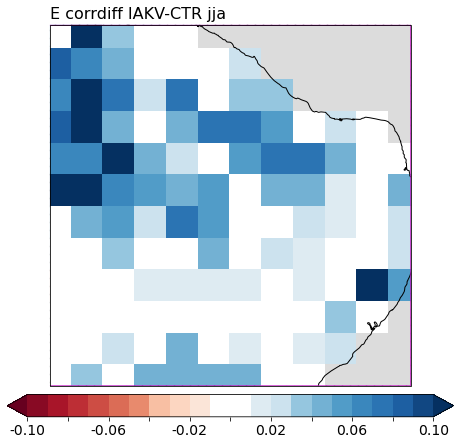

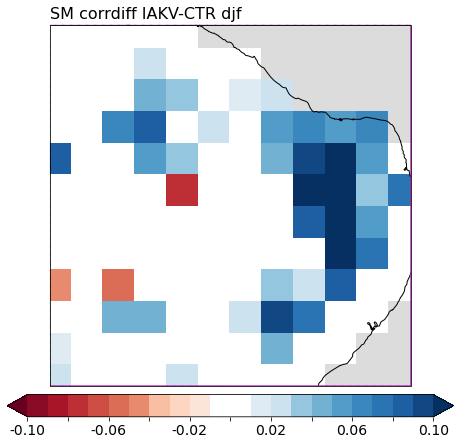

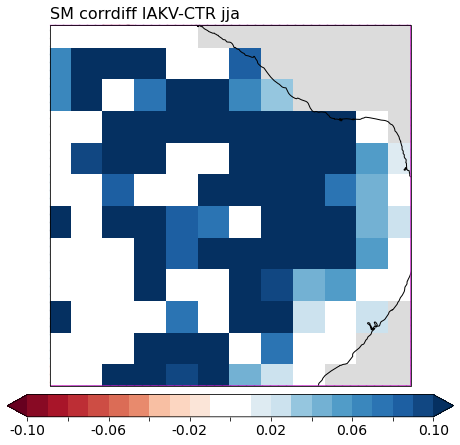

In [13]:
for season in ['djf','jja']:
    ref_data = 'DOLCE_v3'
    start_year = '1999'
    end_year = '2018'
    var = 'hfls'
    reps=1000
    tp = f'ia anomalies {season}'

    if (lon_minb>180):
        lon_minb2 = lon_minb-360
        lon_maxb2 = lon_maxb-360
    else:
        lon_minb2,lon_maxb2 = lon_minb,lon_maxb

    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{season}_{ref_data}_{start_year}_{end_year}_corr_{dt}.nc')

    # calculate correlation
    rd=calculate_correlation_seasons(fol,ref_data,tp,start_year, end_year,var,name1,name2,season,dt)
    r=rd[0]
    r1=rd[1]
    r2=rd[2]

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()

    r1w = r1.where((r1.lat>lat_minb)&(r1.lat<lat_maxb)&(r1.lon>lon_minb)&(r1.lon<lon_maxb))
    r2w = r2.where((r2.lat>lat_minb)&(r2.lat<lat_maxb)&(r2.lon>lon_minb)&(r2.lon<lon_maxb))
    rm1 = r1w.mean().values
    rm2 = r2w.mean().values

    lvls = np.linspace(-0.1,0.1,21)
    lvls3 = np.linspace(-0.1,0.1,11)
    lvls2 = np.linspace(-0.1,0.1,2) 

    n = r.notnull()
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines()
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', hatches=['///'], add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    ax.plot([lon_minb2,lon_maxb2],[lat_maxb,lat_maxb],'m-')
    ax.plot([lon_minb2,lon_maxb2],[lat_minb,lat_minb],'m-')
    ax.plot([lon_minb2,lon_minb2],[lat_minb,lat_maxb],'m-')
    ax.plot([lon_maxb2,lon_maxb2],[lat_minb,lat_maxb],'m-')
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_01)
    ax.set_title(f'E corrdiff {name2}-{name1} {season}',size=16,loc='left')
    ax.set_ylim(lat_minb,lat_maxb)
    ax.set_xlim(lon_minb2+1,lon_maxb2)
    # if (season=='jja'):
    #     ax.annotate(f'$r$ CTR = {np.round(rm1,2)}',(-42.2,-3.8), size=45,color='r')
    #     ax.annotate(f'$r$ IAKV = {np.round(rm2,2)}',(-42.4,-4.9), size=45,color='r')
    # else:
    #     ax.annotate(f'$r$ CTR = {np.round(rm1,2)}0',(-42.2,-3.8), size=45,color='r')
    #     ax.annotate(f'$r$ IAKV = {np.round(rm2,2)}',(-42.4,-4.9), size=45,color='r')
    # fig.savefig(f'{fol}/output_figures/drought/e_corr_{season}.jpg',dpi=300,bbox_inches='tight')

for season in ['djf','jja']:
    start_year = '1999'
    # end_year = '2018'
    reps=1000
    tp = f'ia anomalies {season}'
    layer='layer1'
    th='60'
    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_ia_anomalies_esacci_{season}_{start_year}_{end_year}_corr_{dt}_{th}.nc')
    # plot correlation
    rd=calculate_correlation_SM_esa_seasons(fol,tp,start_year, end_year,name1,name2,layer,season,dt,th)
    r=rd[0]
    r1=rd[1]
    r2=rd[2]

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()

    r1w = r1.where((r1.lat>lat_minb)&(r1.lat<lat_maxb)&(r1.lon>lon_minb)&(r1.lon<lon_maxb))
    r2w = r2.where((r2.lat>lat_minb)&(r2.lat<lat_maxb)&(r2.lon>lon_minb)&(r2.lon<lon_maxb))
    rm1 = r1w.mean().values
    rm2 = r2w.mean().values

    lvls = np.linspace(-0.1,0.1,21)
    lvls3 = np.linspace(-0.1,0.1,11)
    lvls2 = np.linspace(-0.1,0.1,2) 

    n = r.notnull()
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines()
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', hatches=['///'], add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    ax.plot([lon_minb2,lon_maxb2],[lat_maxb,lat_maxb],'m-')
    ax.plot([lon_minb2,lon_maxb2],[lat_minb,lat_minb],'m-')
    ax.plot([lon_minb2,lon_minb2],[lat_minb,lat_maxb],'m-')
    ax.plot([lon_maxb2,lon_maxb2],[lat_minb,lat_maxb],'m-')
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_01)
    ax.set_title(f'SM corrdiff {name2}-{name1} {season}',size=16,loc='left')
    ax.set_ylim(lat_minb,lat_maxb)
    ax.set_xlim(lon_minb2+1,lon_maxb2)
    # if (season=='jja'):
    #     ax.annotate(f'$r$ CTR = {np.round(rm1,2)}0',(-42.2,-3.8), size=45,color='r')
    #     ax.annotate(f'$r$ IAKV = {np.round(rm2,2)}0',(-42.4,-4.9), size=45,color='r')
    # else:
    #     ax.annotate(f'$r$ CTR = {np.round(rm1,2)}',(-42.2,-3.8), size=45,color='r')
    #     ax.annotate(f'$r$ IAKV = {np.round(rm2,2)}',(-42.4,-4.9), size=45,color='r')
    # fig.savefig(f'{fol}/output_figures/drought/sm_corr_{season}.jpg',dpi=300,bbox_inches='tight')


In [14]:
exp5 = xr.open_dataset(f'{fol}/data/exp5_icmcl_yearmean_land2.nc')
cvlt1 = exp5.cvl[0] #cvl in exp7
cvht1 = exp5.cvh[0] #cvl in exp7

cvlt2 = exp5.cvl[:] #cvl in exp6
cvht2 = exp5.cvh[:] #cvl in exp6

if (start_year ==1993):
    cvl_1 = exp5.cvl[14] #1993
else:
    cvl_1 = exp5.cvl[20] #1999

cvl_2 = exp5.cvl[-2] #2019
cvl_diff = cvl_2-cvl_1

if (start_year ==1993):
    cvh_1 = exp5.cvh[14] #1993
else:
    cvh_1 = exp5.cvh[20] #1999

cvh_2 = exp5.cvh[-2] #2019
cvh_diff = cvh_2-cvh_1

cv_1 = cvl_1+cvh_1
cv_2 = cvl_2+cvh_2

if (start_year ==1993):
    tvl_1 = exp5.tvl[14]
    tvh_1 = exp5.tvh[14]
else:
    tvl_1 = exp5.tvl[20]
    tvh_1 = exp5.tvh[20]

tvl_1 = tvl_1.where(tvl_1>0)
tvh_1 = tvh_1.where(tvh_1>0)

tvl_2 = exp5.tvl[-2]
tvh_2 = exp5.tvh[-2]
tvl_2 = tvl_2.where(tvl_2>0)
tvh_2 = tvh_2.where(tvh_2>0)

In [15]:
az_cvl1 = cvl_1.where((cvl_1.lat>lat_minb)&(cvl_1.lat<lat_maxb)&(cvl_1.lon>lon_minb)&(cvl_1.lon<lon_maxb))
az_cvl1 = az_cvl1.mean(dim=['lat','lon']).values
az_cvl2 = cvl_2.where((cvl_2.lat>lat_minb)&(cvl_2.lat<lat_maxb)&(cvl_2.lon>lon_minb)&(cvl_2.lon<lon_maxb))
az_cvl2 = az_cvl2.mean(dim=['lat','lon']).values

az_cvh1 = cvh_1.where((cvh_1.lat>lat_minb)&(cvh_1.lat<lat_maxb)&(cvh_1.lon>lon_minb)&(cvh_1.lon<lon_maxb))
az_cvh1 = az_cvh1.mean(dim=['lat','lon']).values
az_cvh2 = cvh_2.where((cvh_2.lat>lat_minb)&(cvh_2.lat<lat_maxb)&(cvh_2.lon>lon_minb)&(cvh_2.lon<lon_maxb))
az_cvh2 = az_cvh2.mean(dim=['lat','lon']).values

az_tvl1 = tvl_1.where((tvl_1.lat>lat_minb)&(tvl_1.lat<lat_maxb)&(tvl_1.lon>lon_minb)&(tvl_1.lon<lon_maxb))
az_tvl1 = az_tvl1.median(dim=['lat','lon']).values
az_tvl2 = tvl_2.where((tvl_2.lat>lat_minb)&(tvl_2.lat<lat_maxb)&(tvl_2.lon>lon_minb)&(tvl_2.lon<lon_maxb))
az_tvl2 = az_tvl2.median(dim=['lat','lon']).values

az_tvh1 = tvh_1.where((tvh_1.lat>lat_minb)&(tvh_1.lat<lat_maxb)&(tvh_1.lon>lon_minb)&(tvh_1.lon<lon_maxb))
az_tvh1 = az_tvh1.median(dim=['lat','lon']).values
az_tvh2 = tvh_2.where((tvh_2.lat>lat_minb)&(tvh_2.lat<lat_maxb)&(tvh_2.lon>lon_minb)&(tvh_2.lon<lon_maxb))
az_tvh2 = az_tvh2.median(dim=['lat','lon']).values

In [16]:
print('al',az_cvl1,az_cvl2)
print('ah',az_cvh1,az_cvh2)
print('tl',az_tvl1,az_tvl2)
print('th',az_tvh1,az_tvh2)

al 0.8352262 0.8278347
ah 0.1600881 0.16706045
tl 2.0 2.0
th 5.0 5.0


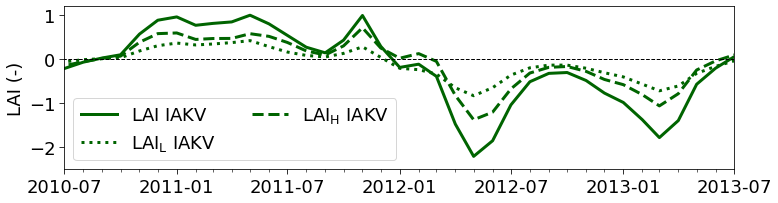

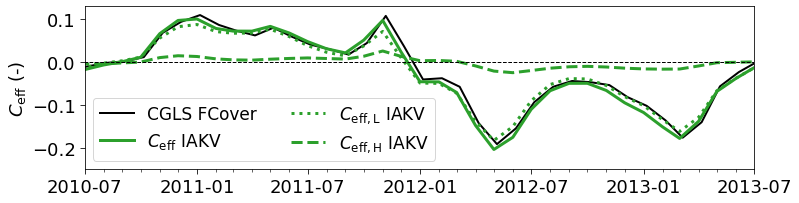

In [17]:
# LAI timeseries anomalies
mod1 = xr.open_dataset(f'{f_mod1}/o_veg_{start_year}_{end_year}_ia_anomalies.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_veg_{start_year}_{end_year}_ia_anomalies.nc')

mod1 = mod1.where((mod1.lat>lat_minb)&(mod1.lat<lat_maxb)&(mod1.lon>lon_minb)&(mod1.lon<lon_maxb))
mod2 = mod2.where((mod2.lat>lat_minb)&(mod2.lat<lat_maxb)&(mod2.lon>lon_minb)&(mod2.lon<lon_maxb))

lail1=mod1.var66.mean(dim=['lat','lon'])
laih1=mod1.var67.mean(dim=['lat','lon'])
lail2=mod2.var66.mean(dim=['lat','lon'])
laih2=mod2.var67.mean(dim=['lat','lon'])
laitot2 = lail2+laih2

cvl1=mod1.CVL.mean(dim=['lat','lon'])
cvh1=mod1.CVH.mean(dim=['lat','lon'])
cvl2=mod2.CVL.mean(dim=['lat','lon'])
cvh2=mod2.CVH.mean(dim=['lat','lon'])
cv1 = cvl1+cvh1
cv2 = cvl2+cvh2

f_fc =f'{fol}/data/eff_cover_fitting'
f = xr.open_dataset(f'{f_fc}/mergetime_fcover_n128_1999_2019_ia_anomalies.nc')
fc = f.FCOVER[:] 
fc = fc.where((fc.lat>lat_minb)&(fc.lat<lat_maxb)&(fc.lon>lon_minb)&(fc.lon<lon_maxb))
fc = fc.mean(dim=['lat','lon'])

# plot timeseries
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax.plot(laitot2.time,laitot2, label='$\mathrm{LAI}$ IAKV',color='darkgreen',linestyle='-',linewidth=3)
ax.plot(lail2.time,lail2, label='$\mathrm{LAI}_{\mathrm{L}}$ IAKV',color='darkgreen',linestyle=':',linewidth=3)
ax.plot(laih2.time,laih2, label='$\mathrm{LAI}_{\mathrm{H}}$ IAKV',color='darkgreen',linestyle='--',linewidth=3)
ax.hlines(0,'1999-01-15','2018-12-31',colors='k',linestyles='--',linewidth=1)
# ax.annotate('$A_\mathrm{L}$='+str(np.round(az_cvl1,2))+', $A_\mathrm{H}$='+str(np.round(az_cvh1,2)),('2012-09-11',0.8), size=19)
# ax.annotate('$T_\mathrm{L}$=Short grass, $T_\mathrm{H}$=EB trees',('2012-04-11',0.36), size=19)
ax.set_xlim(start_date,end_date)
ax.set_xticks(['2010-07-15','2011-01-15','2011-07-15','2012-01-15','2012-07-15','2013-01-15','2013-07-15'])
ax.set_xticklabels(['2010-07','2011-01','2011-07','2012-01','2012-07','2013-01','2013-07'])
ax.set_yticks([-2,-1,0,1,2])
ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='x', which='major',length=5, labelsize=18)
ax.tick_params(axis='x', which='minor',length=3, labelsize=18)
ax.tick_params(axis='y', which='major',length=5, labelsize=18)
ax.tick_params(axis='y', which='minor',length=3, labelsize=18)
ax.set_ylim(-2.5,1.2)
ax.set_ylabel('LAI (-)',fontsize=18)
ax.legend(ncol=2,fontsize=18,loc='lower left')
fig.savefig(f'{fol}/output_figures/drought/LAI_anomalies.jpg',dpi=300,bbox_inches='tight')

# plot timeseries
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax.plot(fc.time,fc, label='CGLS FCover',color='black',linestyle='-',linewidth=2)
ax.plot(cv2.time,cv2, label='$C_\mathrm{eff}$ IAKV',color='tab:green',linestyle='-',linewidth=3)
ax.plot(cv2.time,cvl2, label='$C_\mathrm{eff,L}$ IAKV',color='tab:green',linestyle=':',linewidth=3)
ax.plot(cv2.time,cvh2, label='$C_\mathrm{eff,H}$ IAKV',color='tab:green',linestyle='--',linewidth=3)
ax.hlines(0,'1999-01-15','2018-12-31',colors='k',linestyles='--',linewidth=1)
ax.set_xlim(start_date,end_date)
ax.set_xticks(['2010-07-15','2011-01-15','2011-07-15','2012-01-15','2012-07-15','2013-01-15','2013-07-15'])
ax.set_xticklabels(['2010-07','2011-01','2011-07','2012-01','2012-07','2013-01','2013-07'])
ax.set_yticks([-0.2,-0.1,0.0,0.1])
ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='x', which='major',length=5, labelsize=18)
ax.tick_params(axis='x', which='minor',length=3, labelsize=18)
ax.tick_params(axis='y', which='major',length=5, labelsize=18)
ax.tick_params(axis='y', which='minor',length=3, labelsize=18)
ax.set_ylim(-0.25,0.13)
ax.set_ylabel('$C_\mathrm{eff}$ (-)',fontsize=18)
ax.legend(ncol=2,fontsize=17,loc='lower left')
fig.savefig(f'{fol}/output_figures/drought/FCover_anomalies.jpg',dpi=300,bbox_inches='tight')


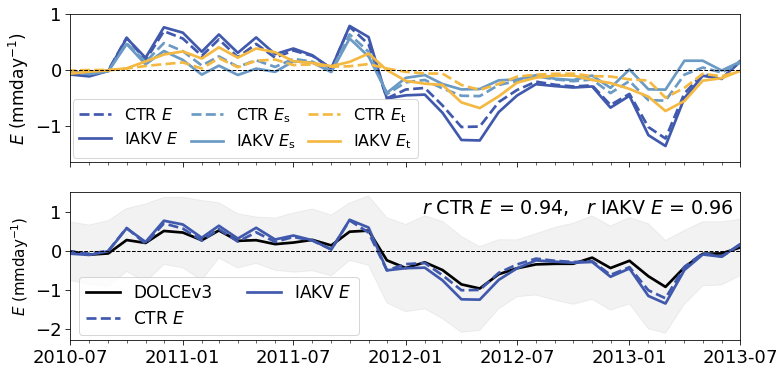

In [18]:
# TIMESERIES ANOMALY E P
mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
mod1 = mod1.where((mod1.lat>lat_minb)&(mod1.lat<lat_maxb)&(mod1.lon>lon_minb)&(mod1.lon<lon_maxb))
mod2 = mod2.where((mod2.lat>lat_minb)&(mod2.lat<lat_maxb)&(mod2.lon>lon_minb)&(mod2.lon<lon_maxb))

et1 = mod1.TVEG * -1000
es1 = mod1.ESOIL * -1000
e1 = mod1.E * -1000
ei1 = mod1.evatc * -1000
p = mod1.TP *1000

et2 = mod2.TVEG * -1000
es2 = mod2.ESOIL * -1000
e2 = mod2.E * -1000
ei2 = mod2.evatc * -1000

et1f = et1.mean(dim=['lat','lon'])
es1f = es1.mean(dim=['lat','lon'])
e1f = e1.mean(dim=['lat','lon'])
ei1f = ei1.mean(dim=['lat','lon'])
pf = p.mean(dim=['lat','lon'])

et2f = et2.mean(dim=['lat','lon'])
es2f = es2.mean(dim=['lat','lon'])
e2f = e2.mean(dim=['lat','lon'])
ei2f = ei2.mean(dim=['lat','lon'])

# DOLCE
tp='fullfield'
ref_data = 'DOLCE_v3'
fol_ref = f'{fol}/data/ref_data'
ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}_ia_anomalies.nc')
ref = ref.where((ref.lat>lat_minb)&(ref.lat<lat_maxb)&(ref.lon>lon_minb)&(ref.lon<lon_maxb))
d_ref = ref.hfls/28.94 # from w/m2 to mm/day
reff = d_ref.mean(dim=['lat','lon'])

refu = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}_fullfield.nc')
refu = refu.where((refu.lat>lat_minb)&(refu.lat<lat_maxb)&(refu.lon>lon_minb)&(refu.lon<lon_maxb))
du = refu.hfls_sd/28.94
dum = du.mean(dim=['lat','lon'])
reffup = reff+dum
reffum = reff-dum

r1 = LE_corr(e1f,reff).values
r2 = LE_corr(e2f,reff).values

# plot timeseries E - met DOLCE
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(211)
# ax.plot(reff.time,reff, label='DOLCEv3', color='black',linewidth=2)
# ax.fill_between(x=reffup.time.values,y1=reffup,y2=reffum,color='grey',alpha=0.13)
pl1,=ax.plot(e1f.time,e1f, label='CTR $E$',color='#4059AD',linestyle='--',linewidth=2.7)
pl2,=ax.plot(e2f.time,e2f, label='IAKV $E$',color='#4059AD',linestyle='-',linewidth=2.7) 
# pl7,=ax.plot(e1f.time,ei1f, label='CTR $E_{\mathrm{i}}$',color='#97D8C4',linestyle='--',linewidth=2.7)
# pl8,=ax.plot(e2f.time,ei2f, label='IAKV $E_{\mathrm{i}}$',color='#97D8C4',linestyle='-',linewidth=2.7)
pl5,=ax.plot(e1f.time,es1f, label='CTR $E_{\mathrm{s}}$',color='#6B9AC4',linestyle='--',linewidth=2.7)
pl6,=ax.plot(e2f.time,es2f, label='IAKV $E_{\mathrm{s}}$',color='#6B9AC4',linestyle='-',linewidth=2.7) 
pl3,=ax.plot(e1f.time,et1f, label='CTR $E_{\mathrm{t}}$',color='#F4B942',linestyle='--',linewidth=2.7)
pl4,=ax.plot(e2f.time,et2f, label='IAKV $E_{\mathrm{t}}$',color='#F4B942',linestyle='-',linewidth=2.7) 

# first_legend = plt.legend(handles=[pl5,pl6],ncol=2,bbox_to_anchor=(0.9,1.02), loc='upper right',fontsize=15)
# plt.gca().add_artist(first_legend)
# plt.legend(handles=[pl1,pl2,pl3,pl4],ncol=2, loc='lower left',fontsize=15)
ax.hlines(0,'1999-01-15','2018-12-31',colors='k',linestyles='--',linewidth=1)
# ax.annotate(f'$r$ CTR $E$ = {np.round(r1,2)}',('2012-11-11',1.25), size=19)
# ax.annotate(f'$r$ IAKV $E$ = {np.round(r2,2)}',('2012-11-01',0.95), size=19)
ax.set_xlim(start_date,end_date)
ax.set_xticks(['2010-07-15','2011-01-15','2011-07-15','2012-01-15','2012-07-15','2013-01-15','2013-07-15'])
ax.set_xticklabels([])
ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='x', which='major',length=5, labelsize=18)
ax.tick_params(axis='x', which='minor',length=3, labelsize=18)
ax.tick_params(axis='y', which='major',length=5, labelsize=18)
ax.tick_params(axis='y', which='minor',length=3, labelsize=18)
ax.set_ylim(-1.65,1)
ax.set_ylabel('$E$ ($\mathrm{mm} \mathrm{day}^{-1}$)',fontsize=17)
ax.legend(ncol=3,loc='lower left',bbox_to_anchor=(-0.008,-0.022),fontsize=16, columnspacing=0.8)
# ax.legend(ncol=2,loc='lower left',bbox_to_anchor=(0.05,-0.018),fontsize=15)

# plot timeseries E - met DOLCE
ax = fig.add_subplot(212)
ax.plot(reff.time,reff, label='DOLCEv3', color='black',linewidth=2.7)
ax.fill_between(x=reffup.time.values,y1=reffup,y2=reffum,color='grey',alpha=0.1)
ax.plot(e1f.time,e1f, label='CTR $E$',color='#4059AD',linestyle='--',linewidth=2.7)
ax.plot(e2f.time,e2f, label='IAKV $E$',color='#4059AD',linestyle='-',linewidth=2.7) 
# ax.plot(e1f.time,et1f, label='CTR $E_{\mathrm{t}}$',color='#F4B942',linestyle='--',linewidth=2)
# ax.plot(e2f.time,et2f, label='IAKV $E_{\mathrm{t}}$',color='#F4B942',linestyle='-',linewidth=2) 
# ax.plot(e1f.time,es1f, label='CTR $E_{\mathrm{s}}$',color='#6B9AC4',linestyle='--',linewidth=2)
# ax.plot(e2f.time,es2f, label='IAKV $E_{\mathrm{s}}$',color='#6B9AC4',linestyle='-',linewidth=2) 
# ax.plot(e1f.time,ei1f, label='CTR $E_{\mathrm{i}}$',color='#97D8C4',linestyle='--',linewidth=2)
# ax.plot(e2f.time,ei2f, label='IAKV $E_{\mathrm{i}}$',color='#97D8C4',linestyle='-',linewidth=2)
ax.hlines(0,'1999-01-15','2018-12-31',colors='k',linestyles='--',linewidth=1)
ax.annotate(f'$r$ CTR $E$ = {np.round(r1,2)},   $r$ IAKV $E$ = {np.round(r2,2)}',('2012-02-11',0.95), size=19)
# ax.annotate(f'$r$ IAKV $E$ = {np.round(r2,2)}',('2012-11-01',0.95), size=19)
ax.set_xlim(start_date,end_date)
ax.set_xticks(['2010-07-15','2011-01-15','2011-07-15','2012-01-15','2012-07-15','2013-01-15','2013-07-15'])
ax.set_xticklabels(['2010-07','2011-01','2011-07','2012-01','2012-07','2013-01','2013-07'])
ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='x', which='major',length=5, labelsize=18)
ax.tick_params(axis='x', which='minor',length=3, labelsize=18)
ax.tick_params(axis='y', which='major',length=5, labelsize=18)
ax.tick_params(axis='y', which='minor',length=3, labelsize=18)
ax.set_ylim(-2.3,1.5)
ax.set_ylabel('$E$ ($\mathrm{mm} \mathrm{day}^{-1}$)',fontsize=15)
ax.legend(ncol=2,loc='lower left',bbox_to_anchor=(0.0,-0.02),fontsize=17)
fig.savefig(f'{fol}/output_figures/drought/E_anomalies1.jpg',dpi=300,bbox_inches='tight')


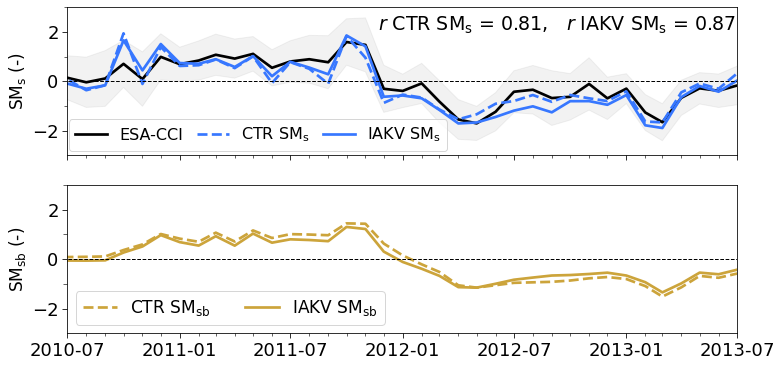

In [19]:
# std anomalies with uncertainty
mod1 = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_stdia_anomalies.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_stdia_anomalies.nc')
mod1 = mod1.where((mod1.lat>lat_minb)&(mod1.lat<lat_maxb)&(mod1.lon>lon_minb)&(mod1.lon<lon_maxb))
mod2 = mod2.where((mod2.lat>lat_minb)&(mod2.lat<lat_maxb)&(mod2.lon>lon_minb)&(mod2.lon<lon_maxb))

sm11 = mod1.SWVL1 #* 0.07 * 1e3 # 7cm
sm12 = mod2.SWVL1 #* 0.07 * 1e3 # 7cm
sm21 = mod1.SWVL2 
sm22 = mod2.SWVL2 
sm31 = mod1.SWVL3 
sm32 = mod2.SWVL3 
sm41 = mod1.SWVL4 
sm42 = mod2.SWVL4 
sm1234 = mod1.SWVL234
sm2234 = mod2.SWVL234
sm11 = sm11.mean(dim=['lat','lon'])
sm12 = sm12.mean(dim=['lat','lon'])
sm21 = sm21.mean(dim=['lat','lon'])
sm22 = sm22.mean(dim=['lat','lon'])
sm31 = sm31.mean(dim=['lat','lon'])
sm32 = sm32.mean(dim=['lat','lon'])
sm41 = sm41.mean(dim=['lat','lon'])
sm42 = sm42.mean(dim=['lat','lon'])
sm1234 = sm1234.mean(dim=['lat','lon'])
sm2234 = sm2234.mean(dim=['lat','lon'])

sm_esa=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2019-stdia_anomalies.nc')
sm_esa = sm_esa.where((sm_esa.lat>lat_minb)&(sm_esa.lat<lat_maxb)&(sm_esa.lon>lon_minb)&(sm_esa.lon<lon_maxb))
sm_esa=sm_esa.sm
sm_esa = sm_esa.mean(dim=['lat','lon'])
sm_esa_u = xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2019-stduncertainty.nc')
sm_esa_u = sm_esa_u.sm_uncertainty
sm_esa_u = sm_esa_u.where((sm_esa_u.lat>lat_minb)&(sm_esa_u.lat<lat_maxb)&(sm_esa_u.lon>lon_minb)&(sm_esa_u.lon<lon_maxb))
sm_esa_u = sm_esa_u.mean(dim=['lat','lon'])
up = sm_esa+sm_esa_u
um = sm_esa-sm_esa_u

r1 = LE_corr(sm11,sm_esa).values
r2 = LE_corr(sm12,sm_esa).values

# SMs and SMsb
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(211)
ax.plot(sm_esa.time,sm_esa, label=f'ESA-CCI',color='black',linestyle='-',linewidth=2.7)
ax.fill_between(x=up.time.values,y1=up,y2=um,color='grey',alpha=0.1)
ax.plot(sm11.time, sm11, label='CTR $\mathrm{SM}_{\mathrm{s}}$',color='#3777FF',linestyle='--',linewidth=2.7)
ax.plot(sm12.time, sm12, label='IAKV $\mathrm{SM}_{\mathrm{s}}$',color='#3777FF',linestyle='-',linewidth=2.7)
ax.set_ylabel('$\mathrm{SM}_{\mathrm{s}}$ (-)', size=17)
ax.hlines(0,'1999-01-15','2018-12-31',colors='k',linestyles='--',linewidth=1)
ax.annotate('$r$ CTR $\mathrm{SM}_{\mathrm{s}}$ = '+str(np.round(r1,2))+',   $r$ IAKV $\mathrm{SM}_{\mathrm{s}}$ = '+str(np.round(r2,2)),('2011-12-05',2.05), size=19)
# ax.annotate('$r$ IAKV $\mathrm{SM}_{\mathrm{s}}$ = '+str(np.round(r2,2)),('2012-10-01',1.1), size=19)
ax.set_xlim(start_date,end_date)
ax.set_xticks(['2010-07-15','2011-01-15','2011-07-15','2012-01-15','2012-07-15','2013-01-15','2013-07-15'])
ax.set_xticklabels([])
ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylim(-3,3)
ax.tick_params(axis='x', which='major',length=5, labelsize=18)
ax.tick_params(axis='x', which='minor',length=3, labelsize=18)
ax.tick_params(axis='y', which='major',length=5, labelsize=18)
ax.tick_params(axis='y', which='minor',length=3, labelsize=18)
ax.legend(ncol=3,fontsize=16,loc='lower left',bbox_to_anchor=(-0.01,-0.023), columnspacing=0.8)

ax = fig.add_subplot(212)
ax.plot(sm1234.time, sm1234, label='CTR $\mathrm{SM}_{\mathrm{sb}}$',color='#CCA43B',linestyle='--',linewidth=2.7)
ax.plot(sm2234.time, sm2234, label='IAKV $\mathrm{SM}_{\mathrm{sb}}$',color='#CCA43B',linestyle='-',linewidth=2.7)
ax.set_ylabel('$\mathrm{SM}_{\mathrm{sb}}$ (-)', size=17)
ax.hlines(0,'1999-01-15','2018-12-31',colors='k',linestyles='--',linewidth=1)
ax.set_xlim(start_date,end_date)
ax.set_xticks(['2010-07-15','2011-01-15','2011-07-15','2012-01-15','2012-07-15','2013-01-15','2013-07-15'])
ax.set_xticklabels(['2010-07','2011-01','2011-07','2012-01','2012-07','2013-01','2013-07'])
ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='x', which='major',length=5, labelsize=18)
ax.tick_params(axis='x', which='minor',length=3, labelsize=18)
ax.tick_params(axis='y', which='major',length=5, labelsize=18)
ax.tick_params(axis='y', which='minor',length=4, labelsize=18)
ax.legend(ncol=4,fontsize=17,loc='lower left')
ax.set_ylim(-3,3)
fig.savefig(f'{fol}/output_figures/drought/SM_std_anomalies.jpg',dpi=300,bbox_inches='tight')
